<a href="https://colab.research.google.com/github/LeeTaeHoon97/Get-distance-from-cam/blob/edit-darknet-and-loss/run_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<!-- colab part -->

In [ ]:
# var rpt = setInterval(()=>{document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click();console.log(new Date);}, 600000);

In [ ]:
	
# clearInterval(rpt);

In [ ]:
!nvidia-smi

Wed Mar 29 16:23:26 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# %cd "/content/drive/MyDrive/Colab Notebooks/data/Get-distance-from-cam_data"

# !unzip -qq "/content/drive/MyDrive/Colab Notebooks/data/Get-distance-from-cam_data/training_data.zip"

In [ ]:
# !unzip -qq "/content/drive/MyDrive/Colab Notebooks/data/Get-distance-from-cam_data/training_label.zip"

In [ ]:
cd "/content/drive/MyDrive/github/Get-distance-from-cam"

/content/drive/MyDrive/github/Get-distance-from-cam


In [ ]:
# !pip install cv

### code start

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from tqdm import tqdm
import cv2
import os

from model import Yolo
# from loss import YoloLoss

In [ ]:
from distutils.command.config import config
import torch.nn as nn
import torch
#본 모델은 13x13의 그리드셀과 5개의 앵커박스, 8개의 클래스로 이루어짐
#S=grid cell , B= anchor box or bounding box, C= num of class
class YoloLoss(nn.Module):
    def __init__(self ,S=13,B=5,C=8):
        super(YoloLoss,self).__init__() #호환을 위해 python 2.0
        self.mse=nn.MSELoss(reduction="sum")
        self.ce=nn.CrossEntropyLoss(reduction='sum')
        self.S=S
        self.B=B
        self.C=C

        self.lambda_noobj=0.5
        self.lambda_coord=5
        self.lambda_zcoord=0.3        #단안카메라 거리측정에 쓰일 loss balance param
        
    
    def forward(self, pred, target):
        #pred per grid cell = [class],  [box c score][box(x,y,w,h)] ... ,[box5 c score], [box5] , [distance]  = 8+5*5+1=34
        #target  =객체가 하나뿐인 이미지 한장의 경우 13개의 그리드 셀로 분류된뒤 13*13*14 의 형태를 가짐 [class],[Pc = confidence score],[x], [y], [w], [h],[distance]   =   1+6=7 (class 는 one hot encoding)  
        #이미지 크기는 앵커박스 도입을 위해 416 * 416으로 변경
        #target에는 c score가 들어가야하기때문에 이미지를 13x13으로 grid cell을 나눈다. 이후 target의 중심 좌표가 속한 grid cell값에 1을 준다. 
        #5개의 앵커박스에서 iou각각 산출 한 뒤 최대값을 찾아냄.
        batch_size=pred.data.size(0)
        
        pred = pred.reshape(-1,self.S,self.S,self.C+self.B*5+1)         #pred는 모델이 산출하여나온 값이 flatten 되어있는 상태, 이를 13x13x34의 형태 reshape
        

        #0~7 = classes, 8=box1 c score , 9~12=pos , 13 = box2 c score ...... 28 = box 5 c score, 29~32 = box5 pos, 33= dist 

        iou_b1 = self.iou(pred[..., 9:13],target[...,9:13])                         #target은 gt bbox로 5개의 앵커박스가 존재하는게 아닌 하나의 bbox를 가짐.
        iou_b2 = self.iou(pred[..., 14:18],target[...,9:13])                        #target idx 0~7 = class, 8=Pc, 9~12 = pos , 13 = distance
        iou_b3 = self.iou(pred[..., 19:23],target[...,9:13])
        iou_b4 = self.iou(pred[..., 24:28],target[...,9:13])
        iou_b5 = self.iou(pred[..., 29:33],target[...,9:13])


        ious= torch.cat([iou_b1.unsqueeze(0),iou_b2.unsqueeze(0),iou_b3.unsqueeze(0),iou_b4.unsqueeze(0),iou_b5.unsqueeze(0)],dim=0)
        
       
        iou_maxes, box_index=torch.max(ious,dim=0)        #bestbox에는 iou값이 가장 큰 bounding box의 index가 저장, iobj(ij) 를 말함.

        exists_box=target[...,8].unsqueeze(3)   #Iobj_i, idx(13,13,8)은 box c score이다. 즉 0이면 존재하지 않고 1이면 존재한다.
                                                # reshape에서 -1,S,S,output 형태로 나눠진 상태인데, 이 중 box c score만 가져오기 위해 unsqueeze(3)을 사용  
                                               
                                                
        bestbox=[pred[..., 8:13],pred[..., 13:18],pred[..., 18:23],pred[..., 23:28],pred[..., 28:33]]        #bestbox는 index(0~4)까지의 박스 인덱스이므로 해당 인덱스에 상응하는 리스트 생성
                                    #해당 박스의 각 elem에는 pred anchor의 c score, x,y,w,h가 들어가 있음.                                    
        
        #Localization Loss
        #Iobj_ij를 명시하지 않은 이유 : bestbox[box_index]를 가져온다는 점에서,box_index의 iobj값이 1이라는걸 시사하기 때문

        values, count = torch.mode(box_index[-1])
        max_iou_idx= torch.mode(values.flatten())[0]
        

        x,y,w,h=target[...,9],target[...,10],target[...,11],target[...,12]
        _, x_hat,y_hat,w_hat,h_hat=bestbox[max_iou_idx][...,0],bestbox[max_iou_idx][...,1],bestbox[max_iou_idx][...,2],bestbox[max_iou_idx][...,3],bestbox[max_iou_idx][...,4]         #에러 발생 시 bestbox의 형태가 어떤형태인지 확인할 필요가 있음, c score를 제외한 x y w h 가 hat변수에 들어감.
        

        localization_loss = exists_box * self.mse(torch.cat((x_hat, y_hat, w_hat, h_hat), dim=-1),
                                          torch.cat((x, y, w, h), dim=-1))
        localization_loss = self.lambda_coord * localization_loss


        # localization_loss = exists_box * self.mse(torch.cat((x_hat, y_hat, torch.sqrt(w_hat), torch.sqrt(h_hat)), dim=-1),
        #                                   torch.cat((x, y, torch.sqrt(w), torch.sqrt(h)), dim=-1))



        # local_loss_part1= self.mse(x_hat,x)+self.mse(y_hat,y)
        
        # # local_loss_part2= self.mse(w_hat,w)+self.mse(h_hat,h)               #no sqrt

        # local_loss_part2= self.mse(torch.sqrt(w_hat),torch.sqrt(w))+self.mse(torch.sqrt(h_hat),torch.sqrt(h))
        
        # local_loss_part2=torch.where(torch.isnan(local_loss_part2), torch.zeros_like(local_loss_part2), local_loss_part2)              #convert nan to 0

        # localization_loss = local_loss_part1+local_loss_part2

        # localization_loss=self.lambda_coord*localization_loss


        # localization_loss=localization_loss*exists_box
        # localization_loss=localization_loss


        #Confidence Loss
        c=target[...,8]
        
        conf_loss=0
        no_conf_loss=0

        # Iobj(ij) and Inoobj(ij)를 명시하지 않은 이유: 존재하든 존재하지 않든 모든경우를 다 계산하기 때문
        for i in range(len(bestbox)):  
            if i == max_iou_idx:  #최대 iou를 가진 anchor box일 경우. ,즉 responsible 또는 Iobj_ij
                c_hat=bestbox[i][...,0]
                conf_loss+=torch.pow((c-c_hat),2)
            else:
                c_hat=bestbox[i][...,0]
                no_conf_loss+=torch.pow((c-c_hat),2)

        confidence_loss=sum(conf_loss) + (self.lambda_noobj * sum(no_conf_loss))

        confidence_loss=confidence_loss.unsqueeze(-1)


        #Classification Loss
        p=target[...,0:8]
        p_hat=pred[...,0:8]

        # p_hat = torch.reshape(p_hat, ( 13, 8))
        # p = torch.reshape(p, ( 13, 8))

        # print('p shape',p.shape)
        # print('p shape',p_hat.shape)


        classification_loss= exists_box * self.mse(p_hat,p)


        #Dsitance Regression Loss
        z=target[...,13]
        z_hat=pred[...,33]
    

        # print("self.lambda_zcoord shape",self.lambda_zcoord.shape)

        distance_regression_loss =  (exists_box * self.mse(z_hat,z))


        distance_regression_loss=self.lambda_zcoord *distance_regression_loss

        loss = localization_loss+ confidence_loss+ classification_loss + distance_regression_loss

        del iou_b1
        del iou_b2
        del iou_b3
        del iou_b4
        del iou_b5
        del ious
        del bestbox
        del pred
        # print("del loss")

        return loss
        # return loss ,localization_loss,confidence_loss,classification_loss,distance_regression_loss
    def iou(self,pred,target):          #yolo dataset은 midpoint 형식의 바운딩박스를 가짐.
                                        #shape = [x,y,w,h]

        #it means,  center x - (width/2) is x start
        pred_box_x1=pred[...,0:1]-(pred[...,2:3]/2)
        pred_box_y1=pred[...,1:2]-(pred[...,3:4]/2)
        pred_box_x2=pred[...,0:1]+(pred[...,2:3]/2)
        pred_box_y2=pred[...,1:2]+(pred[...,3:4]/2)

        
        target_box_x1=target[...,0:1]-(target[...,2:3]/2)
        target_box_y1=target[...,1:2]-(target[...,3:4]/2)
        target_box_x2=target[...,0:1]+(target[...,2:3]/2)
        target_box_y2=target[...,1:2]+(target[...,3:4]/2)
        
        #두 사각형의 겹치는 면적 좌표 구하기
        x1=torch.max(pred_box_x1,target_box_x1)
        y1=torch.max(pred_box_y1,target_box_y1)
        x2=torch.max(pred_box_x2,target_box_x2)
        y2=torch.max(pred_box_y2,target_box_y2)

        intersection=(x2-x1).clamp(0) * (y2-y1).clamp(0)        #torch.clamp(0)을 사용, 만약 두 사각형이 겹치지 않는경우 neg~0사이의 값이 나오므로 이를 0으로 조정 해줌.

        pred_box_area=abs((pred_box_x2-pred_box_x1)*(pred_box_y2-pred_box_y1))
        target_box_area=abs((target_box_x2-target_box_x1)*(target_box_y2-target_box_y1))

        return intersection/(pred_box_area+target_box_area-intersection+ 1e-6)



In [ ]:
# from PIL import Image

# # Open the image file
# with Image.open('/content/drive/MyDrive/Colab Notebooks/data/Get-distance-from-cam_data/image_2/000000.png') as img:
#     # Get the width and height of the image
#     Image_Width, Image_Height = img.size
#     print(f"Image size: {Image_Width} x {Image_Height}")


# #kitti dataset의 실제크기, resize를 위해 파악

In [ ]:

torch.cuda.is_available() 
print(torch.cuda.device_count())

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

1


'cuda'

### 라벨 전처리

In [ ]:
# [class],[Pc = confidence score],[x], [y], [w], [h],[distance] = 0~7 c x y w h dist


In [ ]:
# column_names=['class','truncated','occluded','alpha','x1','y1','x2','y2','dimensions_h','dimensions_w','dimensions_len','location_x','location_y','distance','rotation_y']
# one_hot_labeling={'Car':0, 'Van':1, 'Truck':2,'Pedestrian':3, 'Person_sitting':4, 'Cyclist':5, 'Tram':6,'Misc':7, 'DontCare':7}        #Misc and DontCare is same value


# import os

# folder_path = "dataset/training/label_2"

# #txt파일 단위로 불러옴
# for filename in tqdm(os.listdir(folder_path)):
#     temp=pd.read_csv(folder_path+'/'+filename,delimiter=' ',names=column_names)
#     temp=temp.drop(columns=['truncated','occluded','alpha','dimensions_h','dimensions_w','dimensions_len','location_x','location_y','rotation_y'])

#     #class one hot vector로 변환
#     temp['class'] = np.array(list(map(lambda x:one_hot_labeling[x],list(temp['class'])))).reshape(-1, 1)

 

#     temp

#     # 좌표 resize 416* 416
#     temp['x1'] = ((416.0/Image_Width)*temp['x1'])
#     temp['y1'] = ((416.0/Image_Height)*temp['y1'])
#     temp['x2'] = ((416.0/Image_Width)*temp['x2'])
#     temp['y2'] = ((416.0/Image_Height)*temp['y2'])

#     # x y w h 형식으로 bbox 변환 (여기서 x y는 중심좌표,)   
#     center_x=(temp['x1'] + temp['x2'])/2.0
#     center_y=(temp['y1'] + temp['y2'])/2.0
#     w=temp['x2'] - temp['x1']
#     h=temp['y2'] - temp['y1']
#     temp['x1'] = center_x
#     temp['y1'] = center_y
#     temp['x2'] = w
#     temp['y2'] = h

#     temp.rename(columns = {'x1' : 'x','y1' : 'y','x2' : 'w','y2' : 'h'}, inplace = True)

#     #txt형태로 파일 덮어쓰기 
#     temp.to_csv(folder_path+'/'+filename,sep=' ',index = False , header=None)


# # # #이후 데이터셋에서 텐서로 바꿀때 index 8에 c score 자리 만들기


In [ ]:
int(416/32)


13

In [ ]:
device

'cuda'

### custom dataset

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    # S= grid cell, B= num of anchors, C = num of classes
    def __init__(self, folder_dir, img_dir, label_dir, S=13, B=5, C=8, transform=None):         
        self.img_folder=folder_dir[0]
        self.label_folder=folder_dir[1]
        self.img_path=img_dir
        self.label_path=label_dir
        
        self.S=S
        self.B=B
        self.C=C
        self.transform=transform
        
    def __len__(self):
        return len(self.img_path)
        

    def __getitem__(self, idx):
        
        #image 전처리
        
        image_filepath = self.img_folder+'/'+self.img_path[idx]
        # print(image_filepath)
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (416, 416))
        
        image=image.transpose(2,0,1)
        image=torch.from_numpy(image).float().div(255.0)
        image.requires_grad=True
        #label 추가 전처리

        bboxes=np.loadtxt(self.label_folder+'/'+self.label_path[idx]).tolist()

        label_matrix = torch.zeros((self.S, self.S, self.C+6 )) # 13*13*14(class(8) + c_score x y w h distance)
        
        try:
            for bbox in bboxes:
                # print(bbox)
                class_label=int(bbox[0]) 
                x, y=bbox[1],bbox[2]
                width, height= bbox[3],bbox[4]
                distance= bbox[5]

                # x, y의 위치 grid cell 파악하기
                x_cell = int(x/32) # 0~12
                y_cell = int(y/32) # 0~12
                x_val_inCell = float((x - x_cell * 32.0)/32.0) # 0.0 ~ 1.0
                y_val_inCell = float((y - y_cell * 32.0)/32.0) # 0.0 ~ 1.0

                # w, h 를 0~1 사이의 값으로 만들기
                w = width / 416.0
                h = height / 416.0



                label_matrix[y_cell, x_cell, 8] = 1.0                                       #c_score 8 in pred
                label_matrix[y_cell, x_cell, class_label] = 1.0     #idx 0~7
                label_matrix[y_cell, x_cell, 9] = x_val_inCell                              #bbox 9~12
                label_matrix[y_cell, x_cell, 10] = y_val_inCell
                label_matrix[y_cell, x_cell, 11] = w
                label_matrix[y_cell, x_cell, 12] = h
                label_matrix[y_cell, x_cell, 13] = distance                                 #distance 13
                
                
        # single label
        except TypeError as e:
  
            bbox=bboxes
            class_label=int(bbox[0])
            x, y=bbox[1],bbox[2]
            width, height= bbox[3],bbox[4]
            distance= bbox[5]

            # x, y의 위치 grid cell 파악하기
            x_cell = int(x/32) # 0~12
            y_cell = int(y/32) # 0~12
            x_val_inCell = float((x - x_cell * 32.0)/32.0) # 0.0 ~ 1.0
            y_val_inCell = float((y - y_cell * 32.0)/32.0) # 0.0 ~ 1.0

            # w, h 를 0~1 사이의 값으로 만들기
            w = width / 416.0
            h = height / 416.0

            label_matrix[y_cell, x_cell, 8] = 1.0                                       #c_score 8
            label_matrix[y_cell, x_cell, class_label] = 1.0     #idx 0~7
            label_matrix[y_cell, x_cell, 9] = x_val_inCell                              #bbox 9~12
            label_matrix[y_cell, x_cell, 10] = y_val_inCell
            label_matrix[y_cell, x_cell, 11] = w
            label_matrix[y_cell, x_cell, 12] = h
            label_matrix[y_cell, x_cell, 13] = distance                                 #distance 13
         
        return image.to(device), label_matrix.to(device)

In [ ]:
img_label_folder_path=['/content/drive/MyDrive/Colab Notebooks/data/Get-distance-from-cam_data/image_2','/content/drive/MyDrive/Colab Notebooks/data/Get-distance-from-cam_data/label_2']
img_path=os.listdir('/content/drive/MyDrive/Colab Notebooks/data/Get-distance-from-cam_data/image_2/')
label_path=os.listdir('/content/drive/MyDrive/Colab Notebooks/data/Get-distance-from-cam_data/label_2/')
img_path.sort()
label_path.sort()

In [ ]:
img_path=(img_path[:100])
label_path=(label_path[:100])
len(label_path)
len(img_path)


100

In [ ]:
print(img_path[0] )
print(label_path[0])

000000.png
000000.txt


In [ ]:
dset=CustomDataset(img_label_folder_path,img_path,label_path)

In [ ]:
from torch.utils.data import DataLoader
dataloader = DataLoader(dset, batch_size=8, shuffle=True)

In [ ]:

# for batch_idx, samples in tqdm(enumerate(dataloader)):
#     _,l=samples
#     # print(l[-1][0])
#     break

In [ ]:
# import matplotlib.pyplot as plt

# for batch_idx, (inputs, labels) in enumerate(dataloader):
#     print(labels.shape)

#     inputs= inputs[0]
#     inputs=inputs.to(device)
#     inputs = inputs.permute(1,2,0)
#     print(inputs.shape)
#     plt.figure()
#     plt.imshow(inputs.cpu().detach().numpy())
#     plt.show()
#     break

### model training

In [ ]:
model = Yolo(8).to(device)



In [ ]:
model.parameters()
# del model

<generator object Module.parameters at 0x7efe67ab9c80>

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.00001) 
criterion=YoloLoss()

In [ ]:
# criterion(prediction, y_train)

In [ ]:
loss_lst=[]
lt = len(dset)

In [ ]:
print(next(model.parameters()).is_cuda)

True


In [ ]:
print(device)

cuda


In [ ]:
# !cat /proc/meminfo

In [ ]:
# del dataloader

In [ ]:
nb_epochs = 11
for epoch in range(nb_epochs + 1):
  model.train()
  total_loss=0
  for batch_idx, samples in (enumerate(dataloader)):
    optimizer.zero_grad()
  
    x_train, y_train = samples
    
    x_train, y_train=x_train.to(device), y_train.to(device)
  
    prediction = model(x_train).permute(0, 2, 3, 1)     # y_train과 shape 동일화
    cost = criterion(prediction, y_train)

    cost.mean().backward()
    optimizer.step()
  
    # print(cost)
    print('Epoch {:4d}/{} Batch {}/{} total loss: {:.6f}'.format(
        epoch, nb_epochs, batch_idx+1, len(dataloader),
        cost.mean()
        ))
    total_loss+=cost.mean()
    
    del samples,x_train, y_train, prediction #system Ram 캐시 삭제

  torch.cuda.empty_cache() # GPU 캐시 데이터 삭제

  loss_lst.append(total_loss/lt)

Epoch    0/11 Batch 1/13 total loss: 170286.156250
Epoch    0/11 Batch 2/13 total loss: 131511.031250
Epoch    0/11 Batch 3/13 total loss: 137936.515625
Epoch    0/11 Batch 4/13 total loss: 31279.423828
Epoch    0/11 Batch 5/13 total loss: 29194.656250
Epoch    0/11 Batch 6/13 total loss: 213753.359375
Epoch    0/11 Batch 7/13 total loss: 222555.359375
Epoch    0/11 Batch 8/13 total loss: 31313.343750
Epoch    0/11 Batch 9/13 total loss: 165333.640625
Epoch    0/11 Batch 10/13 total loss: 116926.726562
Epoch    0/11 Batch 11/13 total loss: 163135.796875
Epoch    0/11 Batch 12/13 total loss: 244207.250000
Epoch    0/11 Batch 13/13 total loss: 73382.937500
Epoch    1/11 Batch 1/13 total loss: 161208.265625
Epoch    1/11 Batch 2/13 total loss: 97968.164062
Epoch    1/11 Batch 3/13 total loss: 161033.046875
Epoch    1/11 Batch 4/13 total loss: 173469.562500
Epoch    1/11 Batch 5/13 total loss: 67529.554688
Epoch    1/11 Batch 6/13 total loss: 221076.921875
Epoch    1/11 Batch 7/13 total lo

In [ ]:
torch.save(model.state_dict(), 'saved_model_11epoch')

In [ ]:
print(loss_lst)

[tensor(17308.1621, device='cuda:0', grad_fn=<DivBackward0>), tensor(16202.3623, device='cuda:0', grad_fn=<DivBackward0>), tensor(16008.7832, device='cuda:0', grad_fn=<DivBackward0>), tensor(15247.7686, device='cuda:0', grad_fn=<DivBackward0>), tensor(15043.4395, device='cuda:0', grad_fn=<DivBackward0>), tensor(14942.7783, device='cuda:0', grad_fn=<DivBackward0>), tensor(15916.7637, device='cuda:0', grad_fn=<DivBackward0>), tensor(13941.2148, device='cuda:0', grad_fn=<DivBackward0>), tensor(13490.4258, device='cuda:0', grad_fn=<DivBackward0>), tensor(13642.8857, device='cuda:0', grad_fn=<DivBackward0>), tensor(13938.8770, device='cuda:0', grad_fn=<DivBackward0>), tensor(13587.7148, device='cuda:0', grad_fn=<DivBackward0>)]


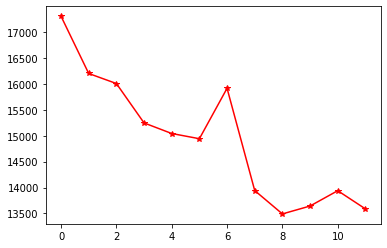

In [ ]:
import matplotlib.pyplot as plt

# Move tensors to CPU and convert to NumPy arrays
loss_np = np.array([x.cpu().detach().numpy() for x in loss_lst])

# Plot the NumPy array
plt.plot(loss_np, marker='*', color='r')
plt.show()

In [ ]:
# img_label_folder_path=['/content/drive/MyDrive/Colab Notebooks/data/Get-distance-from-cam_data/image_2','/content/drive/MyDrive/Colab Notebooks/data/Get-distance-from-cam_data/label_2']
# img_path=os.listdir('/content/drive/MyDrive/Colab Notebooks/data/Get-distance-from-cam_data/image_2/')
# label_path=oas.listdir('/content/drive/MyDrive/Colab Notebooks/data/Get-distance-from-cam_data/label_2/')


#test

In [ ]:
test_img=['000002.png']
test_label=['000002.txt']

In [ ]:
img_label_folder_path

['/content/drive/MyDrive/Colab Notebooks/data/Get-distance-from-cam_data/image_2',
 '/content/drive/MyDrive/Colab Notebooks/data/Get-distance-from-cam_data/label_2']

In [ ]:
testset=CustomDataset(img_label_folder_path,test_img,test_label)
testloader = DataLoader(testset, batch_size=1)

In [ ]:
testloader

In [ ]:
model.eval()

for _,test_samples in enumerate(testloader):
  test_x,test_y=test_samples
  
  test_pred=model(test_x).permute(0, 2, 3, 1)
  print(test_pred.shape)

YOLO_output=test_pred[0].cpu().detach().numpy()
print(YOLO_output.shape)

torch.Size([1, 13, 13, 34])
(13, 13, 34)


In [ ]:
bbox_list = []

In [ ]:
 #pred per grid cell = [class],  [box c score][box(x,y,w,h)] ... ,[box5 c score], [box5] , [distance]  = 8+5*5+1=34

In [ ]:
ClassesinDataSet=['Car', 'Van', 'Truck','Pedestrian', 'Person_sitting', 'Cyclist', 'Tram','Misc']

In [ ]:
def process_bbox(x, y, bbox, classes_score, Classes_inDataSet,dist) : 
    # # size 처리
    bbox_x = bbox[0]
    bbox_y = bbox[1]
    bbox_w = bbox[2]
    bbox_h = bbox[3]
    
    min_x = int(bbox_x - bbox_w/2)
    min_y = int(bbox_y - bbox_h/2)
    max_x = int(bbox_x + bbox_w/2)
    max_y = int(bbox_y + bbox_h/2)
    
    idx_class_highest_score = np.argmax(classes_score)
    class_highest_score = classes_score[idx_class_highest_score] # 가장 높은 class score
    class_highest_score_name = Classes_inDataSet[idx_class_highest_score] # 가장 높은 score를 가진 class의 이름
    
    output_bbox = [min_x, min_y, max_x, max_y, class_highest_score, class_highest_score_name,dist]

    return output_bbox # [x, y, w, h, class_highest_score, class_highest_score_name,dist]로 구성된 list출력
    

In [ ]:
for y in range(0, 13) :
  for x in range(0, 13) :
    # bbox에 있는 20개의 클래스 스코어
    bbox1_class_score = YOLO_output[y][x][:8] * YOLO_output[y][x][8]      #class * conf
    bbox2_class_score = YOLO_output[y][x][:8] * YOLO_output[y][x][13]
    bbox3_class_score = YOLO_output[y][x][:8] * YOLO_output[y][x][18]      #class * conf
    bbox4_class_score = YOLO_output[y][x][:8] * YOLO_output[y][x][23]
    bbox5_class_score = YOLO_output[y][x][:8] * YOLO_output[y][x][28]
        
    # bbox의 사이즈
    bbox1 = YOLO_output[y][x][9:13]
    bbox2 = YOLO_output[y][x][14:18]
    bbox3 = YOLO_output[y][x][19:23]
    bbox4 = YOLO_output[y][x][24:28]
    bbox5 = YOLO_output[y][x][29:33]
    dist= YOLO_output[y][x][33] 
    # 24 -> 6(box info + 가장 높게 나온 클래스 prob + 가장 높게 나온 클래스의 idx)개로 처리
    # opencv는 min_x, min_y, max_x, max_y를 원하니 x, y, w, h를 min, max 좌표로 변환
    process_bbox1 = process_bbox(x, y, bbox1,  bbox1_class_score, ClassesinDataSet,dist)
    process_bbox2 = process_bbox(x, y, bbox2,  bbox2_class_score, ClassesinDataSet,dist)
    process_bbox3 = process_bbox(x, y, bbox3,  bbox3_class_score, ClassesinDataSet,dist)
    process_bbox4 = process_bbox(x, y, bbox4,  bbox4_class_score, ClassesinDataSet,dist)
    process_bbox5 = process_bbox(x, y, bbox5,  bbox5_class_score, ClassesinDataSet,dist)
            
    bbox_list.append(process_bbox1)
    bbox_list.append(process_bbox2)
    bbox_list.append(process_bbox3)
    bbox_list.append(process_bbox4)
    bbox_list.append(process_bbox5)

In [ ]:
def nms(bbox_list) : 
    nms_bbox_list = []
    for i in range(0, len(bbox_list)) :
        
        if bbox_list[i][4] > 0.02 : # class score가 0.2넘기는 것만 출력하기
            nms_bbox_list.append(bbox_list[i])
    
    return nms_bbox_list

In [ ]:
nms_lst=nms(bbox_list)
# bbox_list[1]

In [ ]:
nms_lst

[[0, 0, 0, 0, 0.021676721, 'Car', 0.40258572],
 [0, 0, 0, 0, 0.026298473, 'Car', 1.3817229],
 [0, 0, 0, 0, 0.028836539, 'Pedestrian', 1.4765916],
 [0, 0, 0, 0, 0.022009876, 'Pedestrian', 0.4069754],
 [0, 0, 0, 0, 0.020092504, 'Truck', 1.7388742],
 [0, 0, 0, 0, 0.02481018, 'Car', 1.7388742],
 [0, 0, 0, 0, 0.02542309, 'Truck', 1.7388742],
 [0, 0, 0, 0, 0.02558349, 'Truck', 1.7388742],
 [0, 0, 0, 0, 0.022030314, 'Tram', 0.6396594],
 [0, 0, 0, 0, 0.024811545, 'Pedestrian', 0.6396594],
 [0, 0, 0, 0, 0.026675856, 'Van', 0.16935173],
 [0, 0, 0, 0, 0.027348408, 'Truck', 1.6723503],
 [0, 0, 0, 0, 0.030511709, 'Truck', -5.1706614],
 [0, 0, 0, 0, 0.025929585, 'Truck', -4.818385],
 [0, 0, 0, 0, 0.022086272, 'Truck', -15.510173],
 [0, 0, 0, 0, 0.022911036, 'Truck', -45.022003],
 [0, 0, 0, 0, 0.032975603, 'Misc', -49.20424],
 [0, 0, 0, 0, 0.021132736, 'Truck', -33.097473],
 [0, 0, 0, 0, 0.023146775, 'Truck', -33.097473],
 [0, 0, 0, 0, 0.028175721, 'Car', 0.7941868],
 [0, 0, 0, 0, 0.023908705, 'Pedes

In [ ]:
# bbox_list

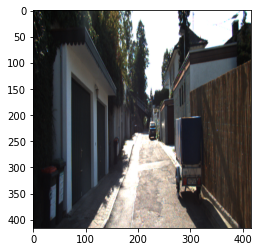

In [ ]:
  import matplotlib.pyplot as plt
  plt.figure()
  plt.imshow(test_x[0].permute(1,2,0).cpu().detach().numpy())
  plt.show()